# Libraries

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import warnings

#Pre Processing
import string
import shutil
import seaborn as sns
import matplotlib.pylab as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from dmba import classificationSummary, regressionSummary
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from dmba import plotDecisionTree, gainsChart, liftChart, classificationSummary, regressionSummary, adjusted_r2_score, AIC_score, BIC_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import recall_score


In [2]:
#os.chdir('C:\\Users\\halle.davis\\Downloads\\') ## Halle's work folder path
#os.chdir('/Users/halledavis/Downloads/') ## Halle's personal folder path
os.chdir('/users/clairephibbs/Desktop/Capstone') ## Claire's folder path
#os.chdir('/Users/summerpurschke/Desktop/Capstone') ## Summer's folder path

In [3]:
accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')

# inspections = pd.read_csv('Inspections.txt', sep= '|', encoding = 'latin-1')
# mines = pd.read_csv('Mines.txt', sep= '|', encoding = 'latin-1')

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_1919/4217344869.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv('Accidents.txt', sep= '|', encoding = 'latin-1')
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_1919/4217344869.py:2: DtypeWarning: Columns (25,34,36,37,43,45,46,55,56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  violations = pd.read_csv('Violations.txt', sep= '|', encoding = 'latin-1')


# Pre-Processing

## Assessing Duplicates

In [4]:
violations.duplicated().sum()

0

In [5]:
accidents.duplicated().sum()

0

INSIGHT: No duplicate values in the violations and accidents dataframes.

## Assessing Nulls

### Violation Data

In [6]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = violations.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

INSPECTION_END_DT                 7665
CONTROLLER_ID                   192131
CONTROLLER_NAME                 192131
VIOLATOR_ID                        120
VIOLATOR_NAME                      135
MINE_TYPE                           21
CONTRACTOR_ID                  2622477
SIG_SUB                          45093
SECTION_OF_ACT                 2796797
PART_SECTION                     30731
SECTION_OF_ACT_2               2811540
ORIG_TERM_DUE_DT                677782
ORIG_TERM_DUE_TIME              677782
LATEST_TERM_DUE_DT               94312
LATEST_TERM_DUE_TIME             94312
TERMINATION_DT                   18626
TERMINATION_TIME                 18626
VACATE_DT                      2812687
VACATE_TIME                    2812687
INITIAL_VIOL_NO                2737136
REPLACED_BY_ORDER_NO           2795513
LIKELIHOOD                       46331
INJ_ILLNESS                      46314
NEGLIGENCE                       46297
WRITTEN_NOTICE                 1440981
ENFORCEMENT_AREA         

In [7]:
# Fill in missing values
violations  = violations.replace('?', np.nan)

### Accident Data

In [8]:
# assessing null values in the df
pd.set_option('display.max_rows', None)

missing_sum = accidents.isna().sum()
print(missing_sum[missing_sum > 0])

pd.reset_option('display.max_rows')

CONTROLLER_ID           719
CONTROLLER_NAME         719
OPERATOR_ID             719
OPERATOR_NAME           719
CONTRACTOR_ID        229611
ACCIDENT_TIME             1
EQUIP_MODEL_NO       151664
SHIFT_BEGIN_TIME        990
NO_INJURIES              24
TOT_EXPER             42602
MINE_EXPER            39673
JOB_EXPER             38873
INJ_BODY_PART            25
SCHEDULE_CHARGE       65023
DAYS_RESTRICT         59928
DAYS_LOST             44754
TRANS_TERM            34368
RETURN_TO_WORK_DT     41033
IMMED_NOTIFY             82
INVEST_BEGIN_DT      203054
NARRATIVE                91
CLOSED_DOC_NO        143124
COAL_METAL_IND          134
dtype: int64


In [9]:
# Fill in missing values
accidents  = accidents.replace('?', np.nan)

### INSPECTION_END_DT Missing Values: Remove INSPECTION_START_DT with year 2023

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_1919/1807657532.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_1919/1807657532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year


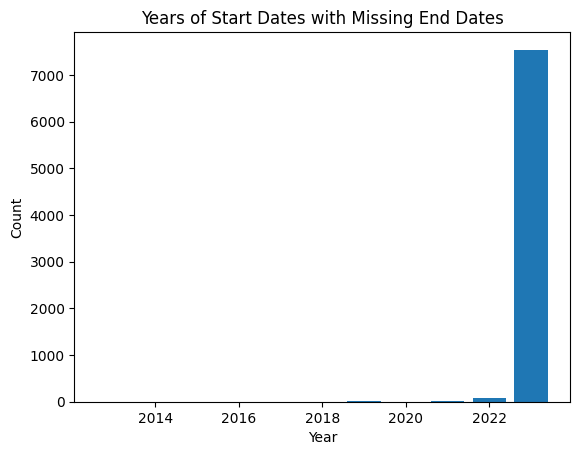

Year
2013       2
2014       1
2015       1
2018       2
2019       9
2020       3
2021      19
2022      86
2023    7542
Name: count, dtype: int64


In [10]:
# Visualizing the missing INSPECTION_END_DT's by year to test theory that majority of missings
# are coming from 2023 because inspection is still ongoing
missing_end_dt = violations[violations['INSPECTION_END_DT'].isnull()]

missing_end_dt['INSPECTION_BEGIN_DT'] = pd.to_datetime(missing_end_dt['INSPECTION_BEGIN_DT'])
missing_end_dt['Year'] = missing_end_dt['INSPECTION_BEGIN_DT'].dt.year
counts_by_year = missing_end_dt['Year'].value_counts().sort_index()

plt.bar(counts_by_year.index, counts_by_year.values)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Years of Start Dates with Missing End Dates')
plt.show()

print(counts_by_year)

INSIGHT: We can see that majority of the inspections with missing end dates are inspections that started in 2023, which makes sense, given that those inspections are likely still ongoing. Would make sense to remove year 2023 of INSPECTION_BEGIN_DT from dataframe. We can also see in counts_by_year that there are some missing end dates for some pretty early years (i.e., 2013, 2014, 2015). Inspection may have been terminated or for some other reason the inspection was never completed, so would make sense to remove these as well.

In [11]:
# Copying dataframe for cleaned data
violations_cleaned = violations.copy()

# Converting 'INSPECTION_BEGIN_DT' to a datetime column 
violations_cleaned['INSPECTION_BEGIN_DT'] = pd.to_datetime(violations_cleaned['INSPECTION_BEGIN_DT'])

# Removing year 2023 from 'INSPECTION_LENGTH_DAYS' in violations df
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_BEGIN_DT'].dt.year != 2023]

In [12]:
# confirming removal of 2023 from 'INSPECTION_BEGIN_DT' column
violations_cleaned['Year'] = violations_cleaned['INSPECTION_BEGIN_DT'].dt.year
violations_cleaned['Year'].value_counts().sort_index()

Year
2000    119520
2001    124165
2002    104371
2003    108413
2004    119971
2005    126672
2006    139122
2007    142686
2008    171914
2009    172486
2010    168977
2011    154499
2012    137519
2013    117695
2014    120269
2015    106260
2016     96407
2017    103712
2018     97202
2019     98521
2020     76781
2021     77177
2022     87185
Name: count, dtype: int64

In [13]:
# Dropping created year column 
violations_cleaned.drop(columns='Year', inplace=True)

# Removing 'INSPECTION_BEGIN_DT' from 2013-2022 with missing values 
violations_cleaned = violations_cleaned[violations_cleaned['INSPECTION_END_DT'].notna()]
display(violations_cleaned.head())
display(violations_cleaned.shape)

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,196.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,55.0,12/04/2000,Paid,01/08/2001,NaN,NaN,N,NaN,0.0,0.0


(2771401, 61)

NOTE: Dataset decreased from 2,812,757 rows to 2,771,401 rows after removing INSPECTION_BEGIN_DT 2023 and missing values in other years from 2013-2022. 

### MINE_TYPE: Filling in Missing Values 

In [14]:
# Viewing the rows with missing value for 'MINE_TYPE', to best see how to address the nulls
missing_mine_type = violations_cleaned[violations_cleaned['MINE_TYPE'].isnull()]
missing_mine_type

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,DOCKET_NO,DOCKET_STATUS_CD,CONTESTED_IND,CONTESTED_DT,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
1620303,6628476,2013-09-17,09/18/2013,8715293,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,0.0
1620304,6628477,2013-09-17,09/23/2013,8715294,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,0.0
1620305,6628477,2013-09-17,09/23/2013,8715295,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,0.0
1620306,6628477,2013-09-17,09/23/2013,8715296,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,0.0
1620307,6628477,2013-09-17,09/23/2013,8715297,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,0.0
1620308,6628477,2013-09-17,09/23/2013,8715298,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,154.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,0.0
1620309,6628477,2013-09-17,09/23/2013,8715299,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,2.0
1620310,6628477,2013-09-17,09/23/2013,8715300,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,2.0
1620311,6628477,2013-09-17,09/23/2013,8796701,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,2.0
1620312,6628477,2013-09-17,09/23/2013,8796702,0112981,Penny Evans,0132753,P E Reliable Equipment Services Inc,Operator,3304704,...,100.0,04/30/2014,Paid,05/15/2014,NaN,NaN,N,NaN,0.0,2.0


INSIGHT: There are two mines with missing values for 'MINE_TYPE', 'MINE_ID' 3304704 and 3402225. Upon research and the data itself, the first Mine 3304704 is a metal producing mine. From the EDA, we know that a large majority of metal producing mines are surface mines, so, to impute the missing values for Mine 3304704, we could fill it in with 'surface'. For the other missing value for 'MINE_TYPE', it is a coal producing mine. Again, from the EDA we know that a large majority of coal producing mines are underground, so we could impute the missing value for mine 3402225 with 'underground'. They could also just be removed given that only 14 MINE_TYPE's are missing values.

Source: https://minesdatabase.com/mines/view/3304704

In [15]:
# Filling in missing values for MINE_TYPE

# MINE_ID 3304704 as MINE_TYPE Surface
violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3304704, 'MINE_TYPE'] = violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3304704, 'MINE_TYPE'].fillna("Surface")

# MINE_ID 3402225 as MINE_TYPE Underground
violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3402225, 'MINE_TYPE'] = violations_cleaned.loc[violations_cleaned['MINE_ID'] == 3402225, 'MINE_TYPE'].fillna("Underground")

### Removing Columns and Rows with High Proportion of Missings

In [16]:
# Removing columns with 24% or more missing values 
violations_cleaned = violations_cleaned.drop(columns=['CONTRACTOR_ID', 'SECTION_OF_ACT_2',
                                             'ORIG_TERM_DUE_DT', 'ORIG_TERM_DUE_TIME', 'VACATE_DT',
                                             'VACATE_TIME', 'INITIAL_VIOL_NO', 'REPLACED_BY_ORDER_NO',
                                             'WRITTEN_NOTICE', 'ENFORCEMENT_AREA', 'PRIMARY_OR_MILL',
                                             'RIGHT_TO_CONF_DT', 'DOCKET_NO', 'DOCKET_STATUS_CD', 'CONTESTED_DT'])

display(violations_cleaned.head())
display(violations_cleaned.shape)


,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0


(2771401, 46)

In [17]:
# Removing rows with more than 5 missing values since there isn't
# a great way to impute our data
violations_cleaned = violations_cleaned.dropna(thresh=violations_cleaned.shape[1] - 5)
display(violations_cleaned.head())
display(violations_cleaned.shape)

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0


(2720784, 46)

NOTE: Dataset size decreased from 2,771,401 to 2,720,784.

In [18]:
violations_cleaned.shape
violations_cleaned.dropna(subset=['NO_AFFECTED', 'NEGLIGENCE', 'LIKELIHOOD', 'MINE_TYPE',
       'COAL_METAL_IND', 'CIT_ORD_SAFE', 'SPECIAL_ASSESS'])
violations_cleaned.shape

(2720784, 46)

## Data Filtering

### VIOLATOR_TYPE_CD: Filter to only operator mines

In [19]:
violations_cleaned = violations_cleaned.loc[violations_cleaned['VIOLATOR_TYPE_CD'] == 'Operator']
display(violations_cleaned.head())
display(violations_cleaned.shape)

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,CONTROLLER_ID,CONTROLLER_NAME,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,0041044,Lhoist Group,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0


(2537146, 46)

In [20]:
violations_cleaned.columns

Index(['EVENT_NO', 'INSPECTION_BEGIN_DT', 'INSPECTION_END_DT', 'VIOLATION_NO',
       'CONTROLLER_ID', 'CONTROLLER_NAME', 'VIOLATOR_ID', 'VIOLATOR_NAME',
       'VIOLATOR_TYPE_CD', 'MINE_ID', 'MINE_NAME', 'MINE_TYPE',
       'COAL_METAL_IND', 'VIOLATION_ISSUE_DT', 'VIOLATION_OCCUR_DT', 'CAL_YR',
       'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'VIOLATION_ISSUE_TIME', 'SIG_SUB',
       'SECTION_OF_ACT', 'PART_SECTION', 'SECTION_OF_ACT_1', 'CIT_ORD_SAFE',
       'LATEST_TERM_DUE_DT', 'LATEST_TERM_DUE_TIME', 'TERMINATION_DT',
       'TERMINATION_TIME', 'TERMINATION_TYPE', 'LIKELIHOOD', 'INJ_ILLNESS',
       'NO_AFFECTED', 'NEGLIGENCE', 'SPECIAL_ASSESS', 'ASMT_GENERATED_IND',
       'FINAL_ORDER_ISSUE_DT', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID',
       'BILL_PRINT_DT', 'LAST_ACTION_CD', 'LAST_ACTION_DT', 'CONTESTED_IND',
       'VIOLATOR_VIOLATION_CNT', 'VIOLATOR_INSPECTION_DAY_CNT'],
      dtype='object')

NOTE: Dataset decreased from 2,720,784 to 2,537,146 after removing 'VIOLATOR_TYPE_CD' == 'Contractor'.

### Unnecessary Feature Removal (CONTROLLER_ID, CONTROLLER_NAME, ASMT_GENERATED_IND, LATEST_TERM_DUE_DT, LATEST_TERM_DUE_TIME, TERMINATION_DT, TERMINATION_TIME)

In [21]:
violations_cleaned = violations_cleaned.drop(columns=['CONTROLLER_ID', 'CONTROLLER_NAME', 'ASMT_GENERATED_IND', 'LATEST_TERM_DUE_DT',
                                                      'LATEST_TERM_DUE_TIME', 'TERMINATION_DT', 'TERMINATION_TIME'])
display(violations_cleaned.head())
display(violations_cleaned.shape)

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,MINE_TYPE,...,FINAL_ORDER_ISSUE_DT,PROPOSED_PENALTY,AMOUNT_DUE,AMOUNT_PAID,BILL_PRINT_DT,LAST_ACTION_CD,LAST_ACTION_DT,CONTESTED_IND,VIOLATOR_VIOLATION_CNT,VIOLATOR_INSPECTION_DAY_CNT
0,711256,2000-01-04,01/07/2000,6089192,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
1,711256,2000-01-04,01/07/2000,6089193,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
2,711256,2000-01-04,01/07/2000,6089194,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
3,711256,2000-01-04,01/07/2000,6089195,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,196.0,196.0,196.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0
4,711256,2000-01-04,01/07/2000,6089196,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,Surface,...,01/10/2001,55.0,55.0,55.0,12/04/2000,Paid,01/08/2001,N,0.0,0.0


(2537146, 39)

In [22]:
# Viewing sum of missing values
violations_cleaned.isna().sum()

EVENT_NO                             0
INSPECTION_BEGIN_DT                  0
INSPECTION_END_DT                    0
VIOLATION_NO                         0
VIOLATOR_ID                          4
VIOLATOR_NAME                        4
VIOLATOR_TYPE_CD                     0
MINE_ID                              0
MINE_NAME                            0
MINE_TYPE                            0
COAL_METAL_IND                       0
VIOLATION_ISSUE_DT                   0
VIOLATION_OCCUR_DT                   0
CAL_YR                               0
CAL_QTR                              0
FISCAL_YR                            0
FISCAL_QTR                           0
VIOLATION_ISSUE_TIME                 0
SIG_SUB                             44
SECTION_OF_ACT                 2524302
PART_SECTION                      9298
SECTION_OF_ACT_1                     0
CIT_ORD_SAFE                         0
TERMINATION_TYPE                     0
LIKELIHOOD                         197
INJ_ILLNESS              

In [23]:
# Converts dataframe to a csv 
# violations_cleaned.to_csv('violations_cleaned.csv', index=False)

## Feature Engineering

### Creating Column: 'INSPECTION_LENGTH_DAYS' from 'INSPECTION_BEGIN_DT' and 'INSPECTION_END_DT'

In [24]:
# Creating new column 'INSPECTION_LENGTH_DAYS' from 'INSPECTION_BEGIN_DT' and 'INSPECTION_END_DT'
violations_cleaned['INSPECTION_LENGTH_DAYS'] = pd.to_datetime(violations_cleaned['INSPECTION_END_DT']) - pd.to_datetime(violations_cleaned['INSPECTION_BEGIN_DT'])

violations_cleaned['INSPECTION_LENGTH_DAYS']

0         3 days
1         3 days
2         3 days
3         3 days
4         3 days
           ...  
2812752   3 days
2812753   3 days
2812754   3 days
2812755   3 days
2812756   3 days
Name: INSPECTION_LENGTH_DAYS, Length: 2537146, dtype: timedelta64[ns]

In [25]:
# Descriptive statistics of 'INSPECTION_LENGTH_DAYS'
violations_cleaned.INSPECTION_LENGTH_DAYS.describe()

count                       2537146
mean     39 days 08:57:39.910308670
std      43 days 05:15:51.829451606
min                 0 days 00:00:00
25%                 2 days 00:00:00
50%                21 days 00:00:00
75%                80 days 00:00:00
max              3500 days 00:00:00
Name: INSPECTION_LENGTH_DAYS, dtype: object

INSIGHT: A new column has been created called 'INSPECTION_LENGTH_DAYS' which represents the number of days between an inspection end date and inspection begin date. The average inspection length is 37 days with a standard deviation of 42 days. After creating the new column, outliers are removed based on standard deviation/z-scores, same method used above to remove outliers. After removing outliers from the INSPECTION_LENGTH_DAYS column, the dataframe decreases from 2,406,620 to 2,391,418.

### Creating Column: 'VIOLATION_SEVERITY' from 'INJ_ILLNESS'

The original variable 'INJ_ILLNESS' is a categorical value assigned to a violation for the gravity of injury. There are 4 possible categories: Fatal, LostDays, NoLostDays, or Permanent. A new column will be created called 'VIOLATION_SEVERITY' that is a numerical representation of the 'INJ_ILLNESS' categories. 0 will be used to denote NoLostDays, 1 for LostDays, 2 for Permanent, and 3 for Fatal.

In [26]:
# Define the mapping dictionary for hierarchical representation
severity_mapping = {
    'Fatal': 3,
    'Permanent': 2,
    'LostDays': 1,
    'NoLostDays': 0
}

# Create the new column 'VIOLATION_SEVERITY' based on the mapping
violations_cleaned['VIOLATION_SEVERITY'] = violations_cleaned['INJ_ILLNESS'].map(severity_mapping)
violations_cleaned['VIOLATION_SEVERITY']

0          3.0
1          3.0
2          1.0
3          3.0
4          2.0
          ... 
2812752    3.0
2812753    3.0
2812754    2.0
2812755    0.0
2812756    0.0
Name: VIOLATION_SEVERITY, Length: 2537146, dtype: float64

### Creating Column: 'SIG_SUB_BINARY' from 'SIG_SUB'

The original variable 'SIG_SUB' has a value of either yes/no. A new column will be created called 'SIG_SUB_BINARY' that is a numerical representation of the 'SIG_SUB' categories. 0 will be used to denote No, and 1 for Yes.

In [27]:
# Change to binary yes or no 
violations_cleaned['SIG_SUB_BINARY'] = violations_cleaned['SIG_SUB'].replace({'N': 0, 'Y': 1})
violations_cleaned['SIG_SUB_BINARY']

0          0.0
1          0.0
2          0.0
3          1.0
4          0.0
          ... 
2812752    1.0
2812753    0.0
2812754    0.0
2812755    0.0
2812756    0.0
Name: SIG_SUB_BINARY, Length: 2537146, dtype: float64

### Creating Column: 'NEGLIGENCE_SCORES' from 'NEGLIGENCE'

In [28]:
# NEGLIGENCE
# Change to Ordinal values
negligence_mapping = {
    'LowNegligence': 1,
    'ModNegligence': 2,
    'HighNegligence': 3,
    'NoNegligence': 0,
    'Reckless': 4
}

violations_cleaned['NEGLIGENCE_SCORE'] = violations_cleaned['NEGLIGENCE'].replace(negligence_mapping)
violations_cleaned['NEGLIGENCE_SCORE']

0          1.0
1          2.0
2          1.0
3          2.0
4          2.0
          ... 
2812752    2.0
2812753    2.0
2812754    2.0
2812755    3.0
2812756    2.0
Name: NEGLIGENCE_SCORE, Length: 2537146, dtype: float64

### Creating Column: 'LIKELIHOOD_SCORE' from 'LIKELIHOOD'

In [29]:
# LIKELIHOOD
# Change to Ordinal values
likelihood_mapping = {
    'Unlikely': 1,
    'Reasonably': 2,
    'NoLikelihood': 0,
    'Highly': 3,
    'Occurred': 4
}

violations_cleaned['LIKELIHOOD_SCORE'] = violations_cleaned['LIKELIHOOD'].map(likelihood_mapping)
violations_cleaned['LIKELIHOOD_SCORE']

0          1.0
1          1.0
2          1.0
3          2.0
4          1.0
          ... 
2812752    2.0
2812753    1.0
2812754    1.0
2812755    0.0
2812756    0.0
Name: LIKELIHOOD_SCORE, Length: 2537146, dtype: float64

### Creating Column: One Hot Encoding

In [30]:
violations_cleaned.SECTION_OF_ACT.value_counts(normalize = True)

SECTION_OF_ACT
316(b)              0.418795
103(h)              0.121224
316(b)(2)(A)        0.087434
103(d)              0.080349
109(a)              0.064622
109(d)              0.054111
316(b)(2)(F)(ii)    0.043989
103(a)              0.026004
104(b)              0.020554
104(a)              0.012613
104(g)(1)           0.011289
316(b)(2)           0.007864
103(j)              0.007708
103(k)              0.006462
110(j)              0.006229
104(d)(1)           0.005139
104(d)(2)           0.004516
115(a)              0.004516
314(b)              0.002491
107(a)              0.002336
316(b)(2)(C)        0.002180
203(a)              0.002024
103(f)              0.001713
109(c)              0.001090
115(e)              0.000545
101(a)(7)           0.000545
115(a)(2)           0.000467
115(a)(3)           0.000389
103(a)(h)           0.000389
115(b)              0.000389
103(b)              0.000234
108(a)(1)(b)        0.000234
115(a)(4)           0.000234
105(c)              0.000234

In [31]:
len(pd.unique(violations['SECTION_OF_ACT']))

46

In [32]:
top10sectionsviolated = ['316(b)', '103(h)', '316(b)(2)(A)', '103(d)', '109(a)', '316(b)(2)(F)(ii)', '103(a)', '104(b)', '104(a)', '104(g)(1)']

#violations_cleaned.loc[~violations_cleaned['SECTION_OF_ACT'].isin(top10sectionsviolated), 'SECTION_OF_ACT_FILTERED'] = violations_cleaned['SECTION_OF_ACT']
violations_cleaned['SECTION_OF_ACT_FILTERED'] = np.where(violations_cleaned['SECTION_OF_ACT'].isin(top10sectionsviolated), violations_cleaned['SECTION_OF_ACT'], '0')

violations_cleaned['SECTION_OF_ACT_FILTERED']

0          0
1          0
2          0
3          0
4          0
          ..
2812752    0
2812753    0
2812754    0
2812755    0
2812756    0
Name: SECTION_OF_ACT_FILTERED, Length: 2537146, dtype: object

In [33]:
violations_cleaned.SECTION_OF_ACT_FILTERED.value_counts(normalize = True)

SECTION_OF_ACT_FILTERED
0                   0.995510
316(b)              0.002120
103(h)              0.000614
316(b)(2)(A)        0.000443
103(d)              0.000407
109(a)              0.000327
316(b)(2)(F)(ii)    0.000223
103(a)              0.000132
104(b)              0.000104
104(a)              0.000064
104(g)(1)           0.000057
Name: proportion, dtype: float64

In [34]:
violations_cleaned = pd.get_dummies(violations_cleaned, columns=['SECTION_OF_ACT_FILTERED', 'MINE_TYPE', 'COAL_METAL_IND', 'CIT_ORD_SAFE', 'SPECIAL_ASSESS'])
violations_cleaned.head()

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,VIOLATION_ISSUE_DT,...,MINE_TYPE_Surface,MINE_TYPE_Underground,COAL_METAL_IND_C,COAL_METAL_IND_M,CIT_ORD_SAFE_Citation,CIT_ORD_SAFE_Notice,CIT_ORD_SAFE_Order,CIT_ORD_SAFE_Safeguard,SPECIAL_ASSESS_N,SPECIAL_ASSESS_Y
0,711256,2000-01-04,01/07/2000,6089192,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,01/04/2000,...,True,False,False,True,True,False,False,False,True,False
1,711256,2000-01-04,01/07/2000,6089193,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,01/04/2000,...,True,False,False,True,True,False,False,False,True,False
2,711256,2000-01-04,01/07/2000,6089194,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,01/04/2000,...,True,False,False,True,True,False,False,False,True,False
3,711256,2000-01-04,01/07/2000,6089195,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,01/04/2000,...,True,False,False,True,True,False,False,False,True,False
4,711256,2000-01-04,01/07/2000,6089196,L13586,"Lhoist North America of Alabama, LLC",Operator,100003,O'Neal Quarry & Mill,01/05/2000,...,True,False,False,True,True,False,False,False,True,False


## Merge Violations and Accidents

For each row in violations, add columns ['Accident_30','Accident_60', 'Accident_90'] as binary columns that show if an accident (or multiple accidents) occurred 30/60/90 days after the violation_data['VIOLATION_OCCUR_DT']. You can find out whether an accident happened in the time following a violation at a specific mine by looking at the accidents dataset, in the row that has the same ['MINE_ID'] value as the violations row that we're looking at. If any accident column (ACCIDENT_1	ACCIDENT_2	ACCIDENT_3....) has a date within 30 days, ['Accident_30'] should be 1. Same logic for 60 and 90 days. This dataset is very large so I rather not iterate through rows if possible

In [35]:
sample_size = 100000

In [36]:
violations_data = violations_cleaned.copy()

In [37]:
# Violation Occur Date is not always the same as Violation Issue Date - 
# Have to decide which one to use 
violations_data[violations_data['VIOLATION_ISSUE_DT'] != violations_data['VIOLATION_OCCUR_DT']][['VIOLATION_ISSUE_DT', 'VIOLATION_OCCUR_DT']]

,VIOLATION_ISSUE_DT,VIOLATION_OCCUR_DT
81,02/17/2009,01/13/2009
82,02/17/2009,01/13/2009
88,02/03/2009,01/18/2009
219,03/17/2016,10/16/2015
293,04/22/2010,03/05/2010
...,...,...
2812322,08/17/2017,08/16/2017
2812362,12/12/2012,12/11/2012
2812615,03/17/2009,03/16/2009
2812616,03/17/2009,03/16/2009


In [38]:
### Create a new df with the dates of accidents at each mine

# Grab just the accident dates and the Mine ID columns from accidents data
accident_dates = accidents[['MINE_ID', 'ACCIDENT_DT']].copy()

# Convert the 'ACCIDENT_DT' column to datetime format using .loc
accident_dates.loc[:, 'ACCIDENT_DT'] = pd.to_datetime(accident_dates['ACCIDENT_DT'], format='%m/%d/%Y')

# Create a new column to count occurrences of accidents for each MINE_ID using .loc
accident_dates.loc[:, 'ACCIDENT_NUMBER'] = accident_dates.groupby('MINE_ID').cumcount() + 1

# Pivot the DataFrame
accident_dates = accident_dates.pivot(index='MINE_ID', columns='ACCIDENT_NUMBER', values='ACCIDENT_DT')

# Rename the columns to have meaningful names
accident_dates.columns = ['ACCIDENT_' + str(i) for i in accident_dates.columns]

# Reset the index if needed
accident_dates = accident_dates.reset_index()

Insight: There are duplicated VIOLATION_NO values

In [39]:
violations_data['VIOLATION_NO'].nunique() == violations_data.shape[0]

False

In [40]:
# Check for duplicate 'VIOLATION_NO' values
duplicates_mask = violations_data.duplicated(subset='VIOLATION_NO', keep=False)

# Select rows with duplicated 'VIOLATION_NO' values
violations_data[duplicates_mask]

,EVENT_NO,INSPECTION_BEGIN_DT,INSPECTION_END_DT,VIOLATION_NO,VIOLATOR_ID,VIOLATOR_NAME,VIOLATOR_TYPE_CD,MINE_ID,MINE_NAME,VIOLATION_ISSUE_DT,...,MINE_TYPE_Surface,MINE_TYPE_Underground,COAL_METAL_IND_C,COAL_METAL_IND_M,CIT_ORD_SAFE_Citation,CIT_ORD_SAFE_Notice,CIT_ORD_SAFE_Order,CIT_ORD_SAFE_Safeguard,SPECIAL_ASSESS_N,SPECIAL_ASSESS_Y
465422,6156330,2008-01-30,02/01/2008,6673447,P24038,Big Ridge Inc,Operator,1103054,Willow Lake Portal,01/30/2008,...,False,True,True,False,True,False,False,False,True,False
465423,6156330,2008-01-30,02/01/2008,6673447,P24038,Big Ridge Inc,Operator,1103054,Willow Lake Portal,01/30/2008,...,False,True,True,False,True,False,False,False,True,False
754539,4206742,2002-01-03,01/28/2002,7531415,P24481,Highlands Mining & Processing Company Inc,Operator,1516011,Mine #4,01/08/2002,...,False,True,True,False,True,False,False,False,True,False
754540,4206742,2002-01-03,01/28/2002,7531415,P24481,Highlands Mining & Processing Company Inc,Operator,1516011,Mine #4,01/08/2002,...,False,True,True,False,True,False,False,False,True,False
754541,4206742,2002-01-03,01/28/2002,7531416,P24481,Highlands Mining & Processing Company Inc,Operator,1516011,Mine #4,01/08/2002,...,False,True,True,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322117,4358107,2006-01-03,04/14/2006,6601251,P24184,Eastern Associated Coal LLC,Operator,4601456,Federal No 2,03/09/2006,...,False,False,True,False,True,False,False,False,True,False
2350191,4052852,2000-08-16,11/09/2000,7088629,P00812,Consolidation Coal Company,Operator,4601968,Monongalia County Mine,09/15/2000,...,False,False,True,False,True,False,False,False,True,False
2350192,4052852,2000-08-16,11/09/2000,7088629,P00812,Consolidation Coal Company,Operator,4601968,Monongalia County Mine,09/15/2000,...,False,False,True,False,True,False,False,False,True,False
2350193,4052852,2000-08-16,11/09/2000,7088630,P00812,Consolidation Coal Company,Operator,4601968,Monongalia County Mine,09/15/2000,...,False,False,True,False,True,False,False,False,True,False


In [41]:
# accidents_violations_merged = violations_data[['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO']].head(1000).merge(accident_dates.head(1000), on = 'MINE_ID', how = 'left')

In [42]:
accidents_violations_merged = violations_data.head(sample_size).merge(accident_dates.head(sample_size), on = 'MINE_ID', how = 'left')

In [43]:
### Method 2 with all other info

# accidents_violations_merged = violations_data.head(1000000).merge(accident_dates.head(1000000), on = 'MINE_ID', how = 'outer')

#Reorder the columns to move 'VIOLATION_NO' and 'MINE_ID' to the first two columns
new_order = ['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO'] + [col for col in accidents_violations_merged.columns if col not in ['VIOLATION_NO', 'MINE_ID']]

# Reassign the DataFrame with the new column order
accidents_violations_merged = accidents_violations_merged[new_order]

In [44]:
### Find the index where the accident date columns start 

# Find the index where the 'ACCIDENT_i' columns start
accident_columns_start_index = accidents_violations_merged.columns.get_loc('ACCIDENT_1')

# Display the index where the 'ACCIDENT_i' columns start
print("The 'ACCIDENT_i' columns start at index:", accident_columns_start_index)

The 'ACCIDENT_i' columns start at index: 63


In [45]:
# There are duplicated columns after the merge - drop them so that the 30/60/90 works
accidents_violations_merged = accidents_violations_merged.iloc[:, ~accidents_violations_merged.columns.duplicated()]

In [46]:
# Check that duplicates were dropped - this was a duplicate
accidents_violations_merged['VIOLATION_OCCUR_DT']

0        01/04/2000
1        01/04/2000
2        01/04/2000
3        01/04/2000
4        01/05/2000
            ...    
99995    11/30/2022
99996    11/30/2022
99997    12/07/2020
99998    12/14/2016
99999    12/14/2016
Name: VIOLATION_OCCUR_DT, Length: 100000, dtype: object

In [47]:
### Columns for if an accident occured at that mine 30/60/90 days after the violation occured

# Convert the 'ACCIDENT_1', 'ACCIDENT_2', etc., columns to datetime format - all columns except the first two
for col in accidents_violations_merged.columns[accident_columns_start_index:]:
    accidents_violations_merged[col] = pd.to_datetime(accidents_violations_merged[col], format='%Y-%m-%d')

# Convert the 'VIOLATION_OCCUR_DT' column to datetime format
accidents_violations_merged['VIOLATION_OCCUR_DT'] = pd.to_datetime(accidents_violations_merged['VIOLATION_OCCUR_DT'], format='%m/%d/%Y')

# Check if any accident date is within 30 days of the violation occurrence date
accident_columns = [col for col in accidents_violations_merged.columns[2:] if 'ACCIDENT' in col]

# Group by 'MINE_ID' and create a list of unique dates for each group
accidents_violations_merged['ACCIDENT_DATES'] = accidents_violations_merged[accident_columns].apply(lambda x: x.dropna().unique(), axis=1)

# Function to check if any date is within 30 days of the violation occurrence date
def check_within_30_days(accident_dates, violation_date):
    if pd.isnull(accident_dates).any():
        return pd.NA
    return any((violation_date <= date <= violation_date + pd.Timedelta(days=30)) for date in accident_dates)

# Function to check if any date is within 60 days of the violation occurrence date
def check_within_60_days(accident_dates, violation_date):
    if pd.isnull(accident_dates).any():
        return pd.NA
    return any((violation_date <= date <= violation_date + pd.Timedelta(days=60)) for date in accident_dates)

# Function to check if any date is within 90 days of the violation occurrence date
def check_within_90_days(accident_dates, violation_date):
    if pd.isnull(accident_dates).any():
        return pd.NA
    return any((violation_date <= date <= violation_date + pd.Timedelta(days=90)) for date in accident_dates)

# Apply the function to create the 'ACCIDENT_30' column
accidents_violations_merged['ACCIDENT_in_30'] = accidents_violations_merged.apply(lambda row: check_within_30_days(row['ACCIDENT_DATES'], row['VIOLATION_OCCUR_DT']), axis=1)

# Apply the function to create the 'ACCIDENT_60' column
accidents_violations_merged['ACCIDENT_in_60'] = accidents_violations_merged.apply(lambda row: check_within_60_days(row['ACCIDENT_DATES'], row['VIOLATION_OCCUR_DT']), axis=1)

# Apply the function to create the 'ACCIDENT_90' column
accidents_violations_merged['ACCIDENT_in_90'] = accidents_violations_merged.apply(lambda row: check_within_90_days(row['ACCIDENT_DATES'], row['VIOLATION_OCCUR_DT']), axis=1)

# Convert the boolean values in 'ACCIDENT_30', 'ACCIDENT_60', and 'ACCIDENT_90' to 1 or 0
accidents_violations_merged['ACCIDENT_in_30'] = accidents_violations_merged['ACCIDENT_in_30'].astype(int)
accidents_violations_merged['ACCIDENT_in_60'] = accidents_violations_merged['ACCIDENT_in_60'].astype(int)
accidents_violations_merged['ACCIDENT_in_90'] = accidents_violations_merged['ACCIDENT_in_90'].astype(int)

# Drop the temporary 'ACCIDENT_DATES' column
accidents_violations_merged = accidents_violations_merged.drop(columns='ACCIDENT_DATES')

/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_1919/3548747735.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  accidents_violations_merged['ACCIDENT_DATES'] = accidents_violations_merged[accident_columns].apply(lambda x: x.dropna().unique(), axis=1)
/var/folders/pf/065skph15m56xshv4vk3x09m0000gn/T/ipykernel_1919/3548747735.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  accidents_violations_merged['ACCIDENT_in_30'] = accidents_violations_merged.apply(lambda row: check_within_30_days(row['ACCIDENT_DATES'], r

In [48]:
# accidents_violations_merged[(accidents_violations_merged['ACCIDENT_in_60']== 1) &(accidents_violations_merged['ACCIDENT_in_90']== 1)][['MINE_ID', 'VIOLATION_OCCUR_DT', 'ACCIDENT_in_30',  'ACCIDENT_in_60',  'ACCIDENT_in_90']]

In [49]:
### Drop all of the Accident Columns 

#List all columns that start with 'ACCIDENT_'
accident_columns_to_drop = [col for col in accidents_violations_merged.columns if col.startswith('ACCIDENT_')]

# Keep only the desired columns: 'ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90'
columns_to_keep = ['ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90']

# Combine the columns to drop and the columns to keep
columns_to_drop = [col for col in accident_columns_to_drop if col not in columns_to_keep]

# Drop the columns from the DataFrame
accidents_violations_merged = accidents_violations_merged.drop(columns=columns_to_drop)

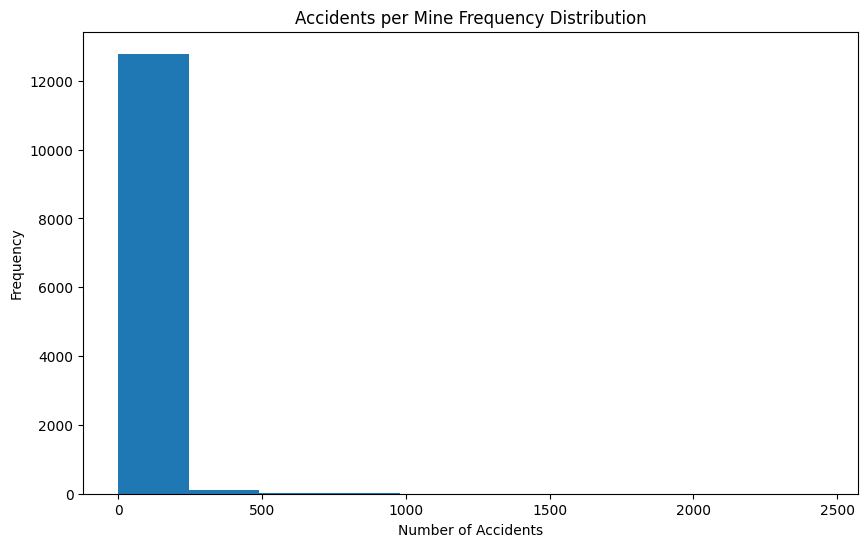

In [50]:
### EDA for Merged

# Count the number of accidents for each mine
accident_counts = accident_dates.iloc[:, 1:].count(axis=1)

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(accident_counts, bins=10)  # Adjust the number of bins as needed

# Set labels and title
plt.xlabel('Number of Accidents')
plt.ylabel('Frequency')
plt.title('Accidents per Mine Frequency Distribution')

# Show the plot
plt.show()

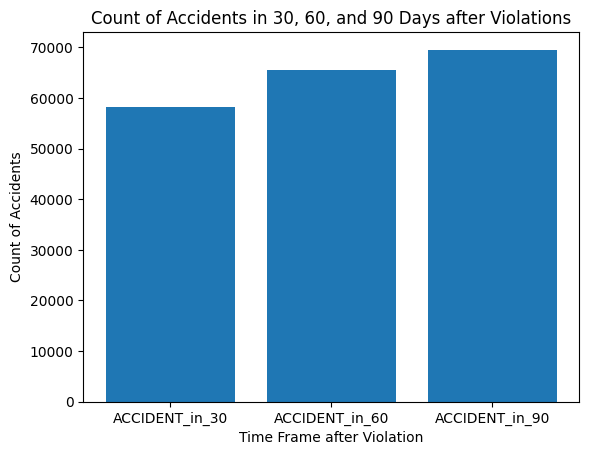

In [51]:
# Count the number of '1's in each column
accident_30_count = accidents_violations_merged['ACCIDENT_in_30'].value_counts()[1]
accident_60_count = accidents_violations_merged['ACCIDENT_in_60'].value_counts()[1]
accident_90_count = accidents_violations_merged['ACCIDENT_in_90'].value_counts()[1]

# Create a list of counts and labels
counts = [accident_30_count, accident_60_count, accident_90_count]
labels = ['ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the bar chart
ax.bar(labels, counts)

# Set labels and title
ax.set_xlabel("Time Frame after Violation")
ax.set_ylabel("Count of Accidents")
ax.set_title("Count of Accidents in 30, 60, and 90 Days after Violations")

# Show the plot
plt.show()

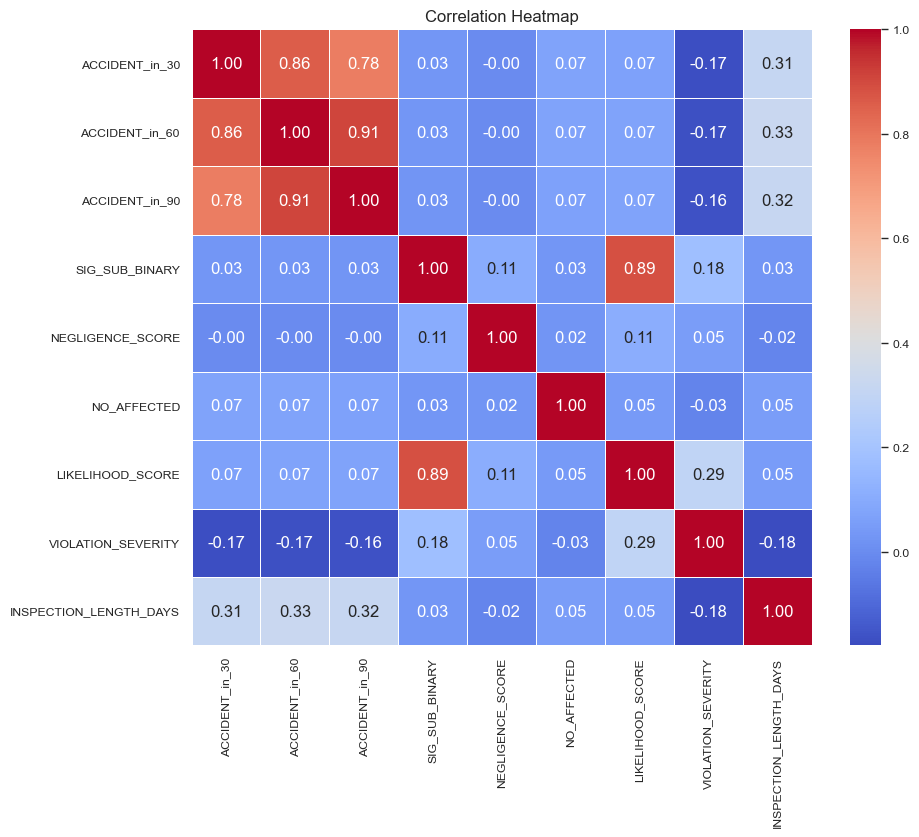

In [52]:
### Correlation between accidents occuring and each of the columns 

# Select the columns for the heatmap
#heatmap_columns = ['ACCIDENT_in_30_TEST', 'ACCIDENT_in_60_TEST', 'ACCIDENT_in_90_TEST', 'SIG_SUB', 'PROPOSED_PENALTY', 'AMOUNT_DUE', 'AMOUNT_PAID', 'NEGLIGENCE', 'NO_AFFECTED', 'LIKELIHOOD']
heatmap_columns = ['ACCIDENT_in_30', 'ACCIDENT_in_60', 'ACCIDENT_in_90', 'SIG_SUB_BINARY', 'NEGLIGENCE_SCORE', 'NO_AFFECTED', 'LIKELIHOOD_SCORE', 'VIOLATION_SEVERITY', 'INSPECTION_LENGTH_DAYS']

# Calculate the correlation matrix
correlation_matrix = accidents_violations_merged[heatmap_columns].corr()

# Set seaborn context and font scale
sns.set(font_scale=1.2)
sns.set_context("paper", rc={"font.size": 12, "axes.titlesize": 12, "axes.labelsize": 12})

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Set title and display the plot
plt.title("Correlation Heatmap")
plt.show()

# Train Test Split

In [66]:
data = accidents_violations_merged.dropna()

In [54]:
accidents_violations_merged.columns

Index(['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO', 'EVENT_NO',
       'INSPECTION_BEGIN_DT', 'INSPECTION_END_DT', 'VIOLATOR_ID',
       'VIOLATOR_NAME', 'VIOLATOR_TYPE_CD', 'MINE_NAME', 'VIOLATION_ISSUE_DT',
       'CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'VIOLATION_ISSUE_TIME',
       'SIG_SUB', 'SECTION_OF_ACT', 'PART_SECTION', 'SECTION_OF_ACT_1',
       'TERMINATION_TYPE', 'LIKELIHOOD', 'INJ_ILLNESS', 'NO_AFFECTED',
       'NEGLIGENCE', 'FINAL_ORDER_ISSUE_DT', 'PROPOSED_PENALTY', 'AMOUNT_DUE',
       'AMOUNT_PAID', 'BILL_PRINT_DT', 'LAST_ACTION_CD', 'LAST_ACTION_DT',
       'CONTESTED_IND', 'VIOLATOR_VIOLATION_CNT',
       'VIOLATOR_INSPECTION_DAY_CNT', 'INSPECTION_LENGTH_DAYS',
       'VIOLATION_SEVERITY', 'SIG_SUB_BINARY', 'NEGLIGENCE_SCORE',
       'LIKELIHOOD_SCORE', 'SECTION_OF_ACT_FILTERED_0',
       'SECTION_OF_ACT_FILTERED_103(a)', 'SECTION_OF_ACT_FILTERED_103(d)',
       'SECTION_OF_ACT_FILTERED_103(h)', 'SECTION_OF_ACT_FILTERED_104(a)',
       'SECTION_OF_ACT_F

In [55]:
data_X = data.drop(columns = ['VIOLATION_OCCUR_DT', 'MINE_ID', 'VIOLATION_NO',
                    'EVENT_NO', 'INSPECTION_BEGIN_DT', 'INSPECTION_END_DT', 'VIOLATOR_ID', 'PART_SECTION',
                    'VIOLATOR_NAME', 'VIOLATOR_TYPE_CD', 'MINE_NAME','VIOLATION_ISSUE_DT', 'SECTION_OF_ACT',
                    'SECTION_OF_ACT_1','CAL_YR', 'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR','VIOLATION_ISSUE_TIME', 'SIG_SUB',
                    'TERMINATION_TYPE','FINAL_ORDER_ISSUE_DT', 'PROPOSED_PENALTY','INJ_ILLNESS',
                    'AMOUNT_DUE', 'AMOUNT_PAID', 'BILL_PRINT_DT', 'LAST_ACTION_CD',
                    'LAST_ACTION_DT', 'CONTESTED_IND', 'VIOLATOR_INSPECTION_DAY_CNT', 'INSPECTION_LENGTH_DAYS',
                    'VIOLATION_SEVERITY', 'SIG_SUB_BINARY', 'NEGLIGENCE', 'LIKELIHOOD','VIOLATOR_VIOLATION_CNT',
                    'ACCIDENT_in_30', 'ACCIDENT_in_60','ACCIDENT_in_90',
                    'CIT_ORD_SAFE_Citation', 'CIT_ORD_SAFE_Notice', 'CIT_ORD_SAFE_Order', 'CIT_ORD_SAFE_Safeguard', 'SPECIAL_ASSESS_N', 'SPECIAL_ASSESS_Y' 
                    ]) #dropping all non predictor columns


In [56]:
data_X.columns

Index(['NO_AFFECTED', 'NEGLIGENCE_SCORE', 'LIKELIHOOD_SCORE',
       'SECTION_OF_ACT_FILTERED_0', 'SECTION_OF_ACT_FILTERED_103(a)',
       'SECTION_OF_ACT_FILTERED_103(d)', 'SECTION_OF_ACT_FILTERED_103(h)',
       'SECTION_OF_ACT_FILTERED_104(a)', 'SECTION_OF_ACT_FILTERED_104(b)',
       'SECTION_OF_ACT_FILTERED_104(g)(1)', 'SECTION_OF_ACT_FILTERED_109(a)',
       'SECTION_OF_ACT_FILTERED_316(b)',
       'SECTION_OF_ACT_FILTERED_316(b)(2)(A)',
       'SECTION_OF_ACT_FILTERED_316(b)(2)(F)(ii)', 'MINE_TYPE_Facility',
       'MINE_TYPE_Surface', 'MINE_TYPE_Underground', 'COAL_METAL_IND_C',
       'COAL_METAL_IND_M'],
      dtype='object')

In [57]:
# Predict 30

X_30 = data_X.copy()
y_30 = data['ACCIDENT_in_30']

X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30,y_30, train_size=0.65, random_state = 42)

X_train_30, X_val_30, y_train_30, y_val_30 = train_test_split(X_train_30, y_train_30, test_size=0.25, random_state=1)

In [58]:
# Predict 60

X_60 = data_X.copy()
y_60 = data['ACCIDENT_in_60']

X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(X_60,y_60, train_size=0.65, random_state = 42)

X_train_60, X_val_60, y_train_60, y_val_60 = train_test_split(X_train_60, y_train_60, test_size=0.25, random_state=1)

In [59]:
# Predict 90

X_90 = data_X.copy()
y_90 = data['ACCIDENT_in_90']

X_train_90, X_test_90, y_train_90, y_test_90 = train_test_split(X_90,y_90, train_size=0.65, random_state = 42)

X_train_90, X_val_90, y_train_90, y_val_90 = train_test_split(X_train_90, y_train_90, test_size=0.25, random_state=1)

In [60]:
X_train_30.head()

,NO_AFFECTED,NEGLIGENCE_SCORE,LIKELIHOOD_SCORE,SECTION_OF_ACT_FILTERED_0,SECTION_OF_ACT_FILTERED_103(a),SECTION_OF_ACT_FILTERED_103(d),SECTION_OF_ACT_FILTERED_103(h),SECTION_OF_ACT_FILTERED_104(a),SECTION_OF_ACT_FILTERED_104(b),SECTION_OF_ACT_FILTERED_104(g)(1),SECTION_OF_ACT_FILTERED_109(a),SECTION_OF_ACT_FILTERED_316(b),SECTION_OF_ACT_FILTERED_316(b)(2)(A),SECTION_OF_ACT_FILTERED_316(b)(2)(F)(ii),MINE_TYPE_Facility,MINE_TYPE_Surface,MINE_TYPE_Underground,COAL_METAL_IND_C,COAL_METAL_IND_M
91183,0,2.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
7090,1,2.0,2.0,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True
93427,0,2.0,0.0,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True
76886,0,2.0,0.0,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
89885,0,2.0,0.0,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True


## Removing Outliers from Training Sets

We waited to remove the outliers in 'NO_AFFECTED' until after partioning the dataset into training and testing sets, to ensure our test sets contain extreme values. This will ensure the quality of model performance on our test sets, since in real-life, there are likely to be outliers in the data that our model will need to deal with.

In [63]:
# Removing outliers from X_train_30

numeric_vars = ['NO_AFFECTED']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed_30 = X_train_30.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((X_train_30[column_name] - X_train_30[column_name].mean()) / X_train_30[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    X_train_30 = outliers_removed_30[z_scores < z_score_threshold]

display(X_train_30.shape)

(93, 19)

In [76]:
# Removing outliers from X_train_60

numeric_vars = ['NO_AFFECTED']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed_60 = X_train_60.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((X_train_60[column_name] - X_train_60[column_name].mean()) / X_train_60[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    X_train_60 = outliers_removed_60[z_scores < z_score_threshold]

display(X_train_60.shape)

(93, 19)

In [75]:
# Removing outliers from X_train_90

numeric_vars = ['NO_AFFECTED']

# Set a threshold for Z-scores to identify outliers
z_score_threshold = 3  # You can adjust this threshold based on your data and requirements

# Create a copy of the original DataFrame to store the outliers removed data
outliers_removed_90 = X_train_90.copy()

# Loop through each column and remove outliers based on Z-scores
for column_name in numeric_vars:
    # Calculate the Z-scores for the current column
    z_scores = np.abs((X_train_90[column_name] - X_train_90[column_name].mean()) / X_train_90[column_name].std())

    # Filter the DataFrame to keep only the rows where the Z-score is less than the threshold for the current column
    X_train_90 = outliers_removed_90[z_scores < z_score_threshold]

display(X_train_90.shape)

(93, 19)

NOTE: No outliers found in 'NO_AFFECTED'.

# Modeling

## Random Forest

In [77]:
# Base 30 
rf_30 = RandomForestClassifier()
rf_30.fit(X_train_30, y_train_30)

rf_pred_30 = rf_30.predict(X_test_30)

print("Random Forest \nBase 30 Model \n")
classificationSummary(y_test_30, rf_pred_30)
print(classification_report(y_test_30, rf_pred_30))

Random Forest 
Base 30 Model 

Confusion Matrix (Accuracy 0.8235)

       Prediction
Actual  0  1
     0 34  1
     1 11 22
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.96      0.67      0.79        33

    accuracy                           0.82        68
   macro avg       0.86      0.82      0.82        68
weighted avg       0.85      0.82      0.82        68



In [78]:
# Tuned 30
rfc=RandomForestClassifier(random_state=42)

In [79]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [80]:
rf_30_tune = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_30_tune.fit(X_val_30, y_val_30)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [81]:
rf_30_tune.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 200}

In [82]:
rf_30_tuned=RandomForestClassifier(random_state=42, n_estimators= 200, max_depth=4, criterion='gini')

In [83]:
rf_30_tuned.fit(X_train_30, y_train_30)

rf_30_tuned_pred = rf_30_tuned.predict(X_test_30)

print("Random Forest \nTuned 30 Model \n")
classificationSummary(y_test_30, rf_30_tuned_pred)
print(classification_report(y_test_30, rf_30_tuned_pred))

Random Forest 
Tuned 30 Model 

Confusion Matrix (Accuracy 0.8235)

       Prediction
Actual  0  1
     0 34  1
     1 11 22
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.96      0.67      0.79        33

    accuracy                           0.82        68
   macro avg       0.86      0.82      0.82        68
weighted avg       0.85      0.82      0.82        68



In [84]:
# Base 60
rf_60 = RandomForestClassifier()
rf_60.fit(X_train_60, y_train_60)

rf_pred_60 = rf_60.predict(X_test_60)

print("Random Forest \nBase 60 Model \n")
classificationSummary(y_test_60, rf_pred_60)
print(classification_report(y_test_60, rf_pred_60))

Random Forest 
Base 60 Model 

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



In [85]:
# Tuned 60
rf_60_tune = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_60_tune.fit(X_val_60, y_val_60)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [86]:
rf_60_tune.best_params_

{'criterion': 'gini', 'max_depth': 4, 'n_estimators': 200}

In [87]:
rf_60_tuned=RandomForestClassifier(random_state=42, n_estimators= 200, max_depth=4, criterion='gini')

In [88]:
rf_60_tuned.fit(X_train_60, y_train_60)

rf_60_tuned_pred = rf_60_tuned.predict(X_test_60)

print("Random Forest \nTuned 60 Model \n")
classificationSummary(y_test_60, rf_60_tuned_pred)
print(classification_report(y_test_60, rf_60_tuned_pred))

Random Forest 
Tuned 60 Model 

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



In [89]:
# Base 90
rf_90 = RandomForestClassifier()
rf_90.fit(X_train_90, y_train_90)

rf_pred_90 = rf_90.predict(X_test_90)

print("Random Forest \nBase 90 Model \n")
classificationSummary(y_test_90, rf_pred_90)
print(classification_report(y_test_90, rf_pred_90))

Random Forest 
Base 90 Model 

Confusion Matrix (Accuracy 0.6324)

       Prediction
Actual  0  1
     0 18  3
     1 22 25
              precision    recall  f1-score   support

           0       0.45      0.86      0.59        21
           1       0.89      0.53      0.67        47

    accuracy                           0.63        68
   macro avg       0.67      0.69      0.63        68
weighted avg       0.76      0.63      0.64        68



In [90]:
# Tuned 90
rf_90_tune = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_90_tune.fit(X_val_90, y_val_90)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [200, 500]})

In [91]:
rf_90_tune.best_params_

{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 200}

In [92]:
rf_90_tuned=RandomForestClassifier(random_state=42, n_estimators= 200, max_depth=4, criterion='gini')

In [93]:
rf_90_tuned.fit(X_train_90, y_train_90)

rf_90_tuned_pred = rf_90_tuned.predict(X_test_90)

print("Random Forest \nTuned 90 Model \n")
classificationSummary(y_test_90, rf_90_tuned_pred)
print(classification_report(y_test_90, rf_90_tuned_pred))

Random Forest 
Tuned 90 Model 

Confusion Matrix (Accuracy 0.6618)

       Prediction
Actual  0  1
     0 20  1
     1 22 25
              precision    recall  f1-score   support

           0       0.48      0.95      0.63        21
           1       0.96      0.53      0.68        47

    accuracy                           0.66        68
   macro avg       0.72      0.74      0.66        68
weighted avg       0.81      0.66      0.67        68



## Logistic Regression

In [94]:
# Tuned 30
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val_30, y_val_30)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best: 0.794444 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786111 (0.213745) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.713889 (0.182172) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.050000) wit

In [95]:
lr_30 = LogisticRegression (penalty="l2" , C=100, solver='newton-cg' )
lr_30.fit(X_train_30, y_train_30)

lr_pred_30 = lr_30.predict(X_test_30)

print("Logistic Regression \nTuned 30 Model \n")
classificationSummary(y_test_30, lr_pred_30)
print(classification_report(y_test_30, lr_pred_30))

Logistic Regression 
Tuned 30 Model 

Confusion Matrix (Accuracy 0.8382)

       Prediction
Actual  0  1
     0 35  0
     1 11 22
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        35
           1       1.00      0.67      0.80        33

    accuracy                           0.84        68
   macro avg       0.88      0.83      0.83        68
weighted avg       0.88      0.84      0.83        68



In [96]:
# Tuned 60
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val_60, y_val_60)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best: 0.794444 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.794444 (0.248824) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.775000 (0.243575) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786111 (0.213745) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.650000 (0.157233) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.713889 (0.182172) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.650000 (0.050000) wit

In [97]:
lr_60 = LogisticRegression (penalty="l2" , C=100, solver='newton-cg' )
lr_60.fit(X_train_60, y_train_60)

lr_pred_60 = lr_60.predict(X_test_60)

print("Logistic Regression \nTuned 60 Model \n")
classificationSummary(y_test_60, lr_pred_60)
print(classification_report(y_test_60, lr_pred_60))

Logistic Regression 
Tuned 60 Model 

Confusion Matrix (Accuracy 0.7794)

       Prediction
Actual  0  1
     0 31  1
     1 14 22
              precision    recall  f1-score   support

           0       0.69      0.97      0.81        32
           1       0.96      0.61      0.75        36

    accuracy                           0.78        68
   macro avg       0.82      0.79      0.78        68
weighted avg       0.83      0.78      0.77        68



In [98]:
# Tuned 90
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_val_90, y_val_90)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


Best: 0.780556 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761111 (0.218087) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761111 (0.218087) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761111 (0.218087) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.750000 (0.230740) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.750000 (0.230740) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.761111 (0.218087) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.780556 (0.197769) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.780556 (0.197769) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.780556 (0.197769) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.741667 (0.131498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.741667 (0.131498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.741667 (0.131498) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.741667 (0.131498) wit

In [99]:
lr_90 = LogisticRegression (penalty="l2" , C=10, solver='liblinear' )
lr_90.fit(X_train_90, y_train_90)

lr_pred_90 = lr_90.predict(X_test_90)
classificationSummary(y_test_90, lr_pred_90)
print(classification_report(y_test_90, lr_pred_90))

Confusion Matrix (Accuracy 0.6618)

       Prediction
Actual  0  1
     0 20  1
     1 22 25
              precision    recall  f1-score   support

           0       0.48      0.95      0.63        21
           1       0.96      0.53      0.68        47

    accuracy                           0.66        68
   macro avg       0.72      0.74      0.66        68
weighted avg       0.81      0.66      0.67        68



## Naive Bayes

In [100]:
# ACCIDENT_in_30 NB model tuning
nb_30 = BernoulliNB()

param_grid_30 = {'alpha': np.linspace(0.1, 1.0, 10)}

grid_search_30 = GridSearchCV(nb_30, param_grid_30, cv=5, scoring='accuracy')
grid_search_30.fit(X_train_30, y_train_30)

alpha_30 = grid_search_30.best_params_['alpha']
alpha_30

0.5

In [101]:
# ACCIDENT_in_30 NB model training
nb_30_model = BernoulliNB(alpha = 0.1)
nb_30_model.fit(X_train_30, y_train_30)

# ACCIDENT_in_30 NB model testing
nb_pred_30 = nb_30_model.predict(X_test_30)

# ACCIDENT_in_30 NB model results
classificationSummary(y_test_30, nb_pred_30)
print(classification_report(y_test_30, nb_pred_30))

Confusion Matrix (Accuracy 0.8382)

       Prediction
Actual  0  1
     0 34  1
     1 10 23
              precision    recall  f1-score   support

           0       0.77      0.97      0.86        35
           1       0.96      0.70      0.81        33

    accuracy                           0.84        68
   macro avg       0.87      0.83      0.83        68
weighted avg       0.86      0.84      0.83        68



In [102]:
# ACCIDENT_in_60 NB model tuning
nb_60 = BernoulliNB()

param_grid_60 = {'alpha': np.linspace(0.1, 1.0, 10)}

grid_search_60 = GridSearchCV(nb_60, param_grid_60, cv=5, scoring='accuracy')
grid_search_60.fit(X_train_60, y_train_60)

alpha_60 = grid_search_60.best_params_['alpha']
alpha_60

0.4

In [103]:
# ACCIDENT_in_60 NB model training
nb_60_model = BernoulliNB(alpha = 0.1)
nb_60_model.fit(X_train_60, y_train_60)

# ACCIDENT_in_60 NB model testing
nb_pred_60 = nb_60_model.predict(X_test_60)

# ACCIDENT_in_60 NB model results
classificationSummary(y_test_60, nb_pred_60)
print(classification_report(y_test_60, nb_pred_60))

Confusion Matrix (Accuracy 0.7941)

       Prediction
Actual  0  1
     0 31  1
     1 13 23
              precision    recall  f1-score   support

           0       0.70      0.97      0.82        32
           1       0.96      0.64      0.77        36

    accuracy                           0.79        68
   macro avg       0.83      0.80      0.79        68
weighted avg       0.84      0.79      0.79        68



In [104]:
# ACCIDENT_in_90 NB model tuning
nb_90 = BernoulliNB()

param_grid_90 = {'alpha': np.linspace(0.1, 1.0, 10)}

grid_search_90 = GridSearchCV(nb_90, param_grid_90, cv=5, scoring='accuracy')
grid_search_90.fit(X_train_90, y_train_90)

alpha_90 = grid_search_90.best_params_['alpha']
alpha_90

0.1

In [105]:
# ACCIDENT_in_90 NB model training
nb_90_model = BernoulliNB(alpha = 0.1)
nb_90_model.fit(X_train_90, y_train_90)

# ACCIDENT_in_90 NB model testing
nb_pred_90 = nb_90_model.predict(X_test_90)

# ACCIDENT_in_90 NB model results
classificationSummary(y_test_90, nb_pred_90)
print(classification_report(y_test_90, nb_pred_90))

Confusion Matrix (Accuracy 0.6324)

       Prediction
Actual  0  1
     0 20  1
     1 24 23
              precision    recall  f1-score   support

           0       0.45      0.95      0.62        21
           1       0.96      0.49      0.65        47

    accuracy                           0.63        68
   macro avg       0.71      0.72      0.63        68
weighted avg       0.80      0.63      0.64        68



## SVM

## GBM

## 